In [0]:
#loading two CSV files into Apache Spark dataframes.
steam_200k_dataframe = spark.read.csv("/FileStore/tables/steam_200k-3.csv", header = False, inferSchema = True)\
    .toDF("Unique_Identifier", "Game_Title", "Behaviour", "Result") #contain user behaviors on Steam, like whether users bought or played specific games, with a unique identifier for each entry.
games_dataframe = spark.read.csv("/FileStore/tables/games.csv", header = False, inferSchema = True)\
    .toDF("game_ID", "Game_Title") #a reference table mapping game titles to a specific game ID.


In [0]:
# So as to join the two DataFrames (`steam_200k_dataframe` and `games_dataframe`) on the "Game_Title" column using an inner join, and select and create a new DataFrame containing only the specified columns that we need in order to carry on the further tasks: "Unique_Identifier", "Game_ID", "Behaviour", and "Result".

Combined_steam_gamedataframe = steam_200k_dataframe.join(games_dataframe, on = "Game_Title", how = "inner").select("Unique_Identifier", "Game_ID", "Behaviour", "Result")

In [0]:
#importing the col function from PySpark SQL 
from pyspark.sql.functions import col

# select specific columns from the DataFrame Combined_steam_gamedataframe, casting the "Unique_Identifier" and "Game_ID" columns to integer type, and the "Result" column to float type.
type_casted_steam_game_dataframe = Combined_steam_gamedataframe.select(col("Unique_Identifier").cast("int"), col("Game_ID").cast("int"), col("Result").cast("float"))

In [0]:
(training, test) = type_casted_steam_game_dataframe.randomSplit([0.75,0.25])
# splits  DataFrame type_casted_steam_game_dataframe of Steam game data into two separate DataFrames for training and testing, with 75% of the data assigned to the training set and 25% to the test set, ensuring that each set retains a similar distribution of data.

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, desc, avg, round
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session 
spark = SparkSession.builder.appName("SteamDataAnalysis").getOrCreate()

# Display schema and first few rows to understand the data structure of "type_casted_steam_game_dataframe"
type_casted_steam_game_dataframe.printSchema()
type_casted_steam_game_dataframe.show(5)

# EDA: Find the top 5 games by frequency of user behavior
top_5_games = type_casted_steam_game_dataframe.groupBy("Game_ID") \
    .agg(count("*").alias("frequency")) \
    .orderBy(desc("frequency")) \
    .limit(5)

print("Top 5 games by frequency of user behavior:")
top_5_games.show()


root
 |-- Unique_Identifier: integer (nullable = true)
 |-- Game_ID: integer (nullable = true)
 |-- Result: float (nullable = true)

+-----------------+-------+------+
|Unique_Identifier|Game_ID|Result|
+-----------------+-------+------+
|        151603712|      1|   1.0|
|        151603712|      1| 273.0|
|        151603712|      2|   1.0|
|        151603712|      2|  87.0|
|        151603712|      3|   1.0|
+-----------------+-------+------+
only showing top 5 rows

Top 5 games by frequency of user behavior:
+-------+---------+
|Game_ID|frequency|
+-------+---------+
|     22|     9682|
|     10|     4646|
|     54|     2789|
|    529|     2632|
|      5|     1752|
+-------+---------+



In [0]:

# EDA: Determine the distribution of behavior types
behavior_distribution = type_casted_steam_game_dataframe.groupBy("Result") \
    .agg(count("*").alias("frequency")) \
    .orderBy(desc("frequency"))

print("Distribution of behavior types:")
behavior_distribution.show()


Distribution of behavior types:
+------+---------+
|Result|frequency|
+------+---------+
|   1.0|   130569|
|   0.2|     3016|
|   0.3|     2517|
|   0.4|     2129|
|   0.5|     1813|
|   0.1|     1787|
|   0.6|     1643|
|   0.7|     1380|
|   0.8|     1278|
|   0.9|     1229|
|   1.1|      948|
|   1.2|      943|
|   1.3|      913|
|   1.4|      829|
|   1.5|      797|
|   1.7|      696|
|   1.6|      686|
|   1.9|      647|
|   1.8|      645|
|   2.0|      601|
+------+---------+
only showing top 20 rows



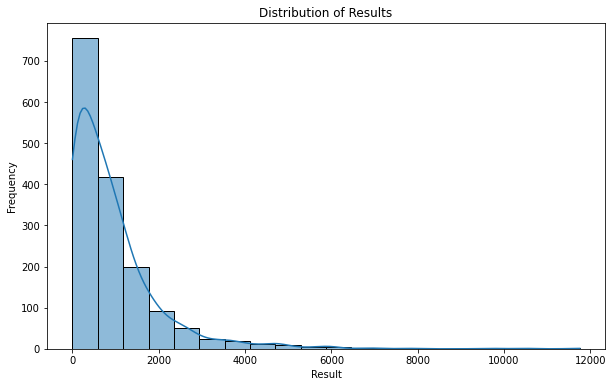

In [0]:

# EDA: Plot the distribution of results (e.g., scores or ratings)
result_distribution = type_casted_steam_game_dataframe.groupBy("Result") \
    .agg(count("*").alias("frequency"))

# Convert to Pandas for visualization
result_dist_pd = result_distribution.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=result_dist_pd, x="Result", bins=20, kde=True)
plt.title("Distribution of Results")
plt.xlabel("Result")
plt.ylabel("Frequency")
plt.show()


In [0]:

# EDA: Investigate user interaction with games
# Get the count of unique users and their average behavior
unique_users = type_casted_steam_game_dataframe.agg(countDistinct("Unique_Identifier").alias("unique_users")).collect()[0]["unique_users"]
average_result = type_casted_steam_game_dataframe.agg(round(avg("Result"), 2).alias("average_result")).collect()[0]["average_result"]

print(f"Total unique users: {unique_users}")
print(f"Average result: {average_result}")


Total unique users: 12393
Average result: 17.87


In [0]:
from pyspark.ml.recommendation import ALS

# Configure ALS with the correct parameters
als = ALS(
    maxIter=5, 
    regParam=0.01, 
    userCol="Unique_Identifier", 
    itemCol="Game_ID", 
    ratingCol="Result", 
    coldStartStrategy="drop"
)

# Assuming 'training' is a DataFrame containing the training data
model = als.fit(training)


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming 'model' is a trained ALS model and 'test' is the test dataset
predictions = model.transform(test)

# Create an evaluator for measuring RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Result",
    predictionCol="prediction"  # Note: "prediction" is the default name of the predictions column
)

# Evaluate the predictions using RMSE
rmse = evaluator.evaluate(predictions)

print("Root Mean Square Error (RMSE):", rmse)


Root Mean Square Error (RMSE): 229.1233231711882


In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Define parameters for tuning
parameters_for_tuning = {
    'rank': [5, 10, 15],
    'maxIter': [5, 10, 15],
    'regParam': [0.01, 0.05, 0.1]
}

# Define a function to train and evaluate the model with parameter tuning
def to_train_and_evaluate_model(training, test, parameters_for_tuning):
    # Create an ALS instance
    als = ALS(
        userCol="Unique_Identifier",
        itemCol="Game_ID",
        ratingCol="Result",
        coldStartStrategy="drop"
    )

    # Create a grid of parameters for tuning
    grid_parameters = ParamGridBuilder()\
        .addGrid(als.rank, parameters_for_tuning['rank'])\
        .addGrid(als.maxIter, parameters_for_tuning['maxIter'])\
        .addGrid(als.regParam, parameters_for_tuning['regParam'])\
        .build()

    # Set up an evaluator for RMSE
    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Result",
        predictionCol="prediction"
    )

    # Set up cross-validation with ALS as the estimator
    crossval = CrossValidator(
        estimator=als,
        estimatorParamMaps=grid_parameters,
        evaluator=evaluator,
        numFolds=5
    )

    # Fit the cross-validation model on the training data
    cv_model = crossval.fit(training)

    # Generate predictions on the test data
    predictions = cv_model.transform(test)

    # Calculate RMSE to evaluate model performance
    rmse = evaluator.evaluate(predictions)

    return cv_model, rmse


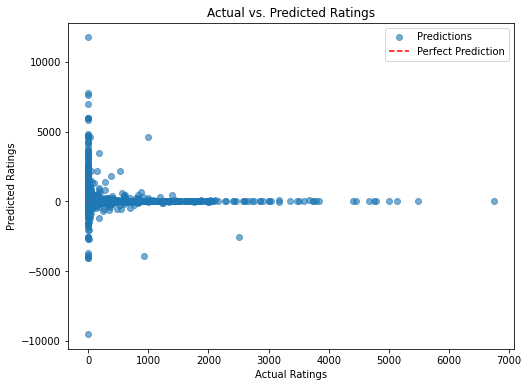

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
predictions_pd = predictions.select("Unique_Identifier", "Game_ID", "Result", "prediction").toPandas()
# Scatter plot of actual vs. predicted ratings
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd['Result'], predictions_pd['prediction'], alpha=0.6, label='Predictions')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.plot([1, 5], [1, 5], '--', color='red', label='Perfect Prediction')  # Add a reference line
plt.legend()
plt.show()

In [0]:
print("Root Mean Square Error (RMSE):", rmse)


Root Mean Square Error (RMSE): 229.1233231711882


In [0]:
predictions.show(5)  # Displays the first 5 rows


+-----------------+-------+------+-----------+
|Unique_Identifier|Game_ID|Result| prediction|
+-----------------+-------+------+-----------+
|             5250|     10|   1.0| 0.76319885|
|             5250|     92|  13.6| 0.21047044|
|             5250|    206|   1.0|-0.63129246|
|             5250|    389|   1.0| 0.16952288|
|             5250|    552|   1.0|-0.17811042|
+-----------------+-------+------+-----------+
only showing top 5 rows



In [0]:
predictions.select("Unique_Identifier", "Game_ID", "Result", "prediction").show(10)  # Display a few rows for comparison


+-----------------+-------+------+-----------+
|Unique_Identifier|Game_ID|Result| prediction|
+-----------------+-------+------+-----------+
|         16167221|    107|  13.0|  1.3226364|
|         16167221|    395|   1.0|  1.7747333|
|         16167221|    396|   1.0|  1.7059444|
|         16167221|    568|   1.0|-0.10852814|
|         16167221|    611|   1.0|   9.679347|
|         16167221|    611| 722.0|   9.679347|
|         16167221|    613|   1.0| 0.61462915|
|         16167221|    613|   2.8| 0.61462915|
|         16167221|   1020|   1.0|  16.478968|
|         16167221|   1292|   1.0|0.020038605|
+-----------------+-------+------+-----------+
only showing top 10 rows

